In [1]:
# ------------------------------------------#
#        Expt 5: Perform a battery of negative inference tests from a single script and plot results, save metadata    
# ------------------------------------------#

Threads.nthreads()
begin
    using LinearAlgebra 
    using Plots
    using FFTW
    using FileIO
    using JLD2
    using DiffEqFlux
    using OrdinaryDiffEq
    using BlockArrays
    using LaTeXStrings
    using SparseArrays
    using BSON
    using Distances
    using DifferentialEquations
    using Optimization
    using OptimizationPolyalgorithms
    using Zygote
    using OptimizationOptimJL
    using OptimizationOptimisers
    using DiffEqSensitivity
    using DelimitedFiles
    using HDF5
    using Plots
    using InvertedIndices
    using Random
    using Statistics
    using DiffEqCallbacks
    using Test
end 

In [2]:
filename = "/home/tschala/research/LANL/case1_1_1D_waveforms_results.h5"
file = h5open(filename, "r")
# Read the dataset
data1d = read(file["data"])

# Close the file
close(file)

In [3]:
println("Size of 1D data matrix:",size(data1d))
println("Shape: [timesteps,spatial locations,waveforms,variables]")

# note that some elements in space a duplicate
# the real spatial size is 100

Size of 1D data matrix:(300, 110, 47, 4)
Shape: [timesteps,spatial locations,waveforms,variables]


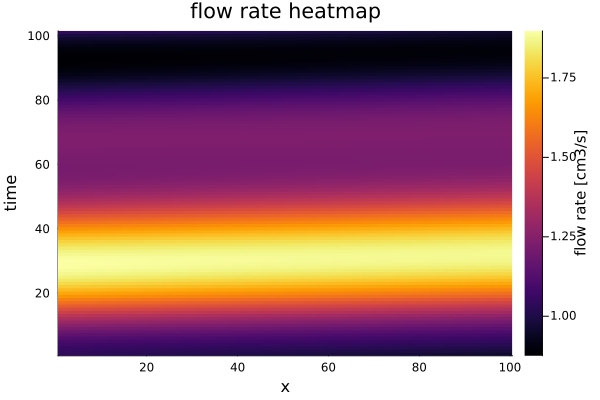

In [4]:
# remove duplicate data (both ends of a segment are saved)
data1d_fix = data1d[200:end,Not(11:11:end),:,:];

heatmap(data1d_fix[:,:,20,1], title="flow rate heatmap", cbar_title = "flow rate [cm3/s]")
xlabel!("x")
ylabel!("time")


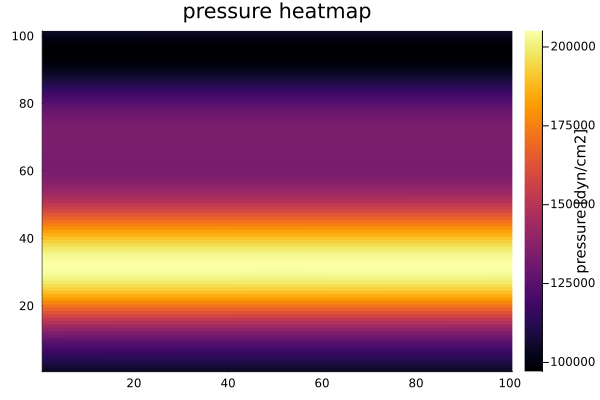

In [5]:
heatmap(data1d_fix[1:end,:,20,2], title="pressure heatmap", cbar_title = "pressure [dyn/cm2]")

In [6]:
begin
    global dt = 0.01                     # time step
    global T = 1.0                   # total time
    global tsteps = 0.0:dt:T             # discretized time dimension
    global tspan = (0,T)                 # end points of time integration for ODEProbem
    global L = 4.0                       # total length of 1d sim
    global train_maxiters = 5         # number of iterations of learning
    global learning_rate  = 0.01         # learning rate , currently using PolyOpt default (0.1)


end

0.01

In [7]:
#waveforms to use
waveforms = 10


# Set the seed for reproducibility
Random.seed!(1234)

# Shuffle the indices of the vector
shuffled_indices = randperm(size(data1d_fix)[3])

# Divide the shuffled indices into training and test sets
train_indices = shuffled_indices[1:waveforms];
test_indices = shuffled_indices[waveforms+1:end];

# # Shuffle the indices of the vector
# shuffled_indices = 1:47

# # Divide the shuffled indices into training and test sets
# train_indices = shuffled_indices[18:end];
# test_indices = shuffled_indices[1:17];

# select field variable ID
# 1 - flow rate, 2 - pressure, 3 - area, 4 - Wall Shear Stress
pID = 1

1

In [8]:
#define IC's
u0 = data1d_fix[1,1:end,train_indices,pID];
u01 = data1d_fix[1,1:end,1,pID];

u0_test = data1d_fix[1,1:end,test_indices,pID];

In [9]:
#ground truth data
ytrain2 = data1d_fix[:,1:end,train_indices,pID];
ytrain21 = data1d_fix[:,1:end,1,pID];

ytest2 = data1d_fix[:,1:end,test_indices,pID];

#boundary conditions
bc_flow = data1d_fix[:,1,train_indices,pID];
bc_flow1 = bc_flow[:,1];

bc_flow_test = data1d_fix[:,1,test_indices,pID];

In [10]:
aID = 3
#ground truth data for area
Atrain = data1d_fix[:,1:end,train_indices,aID];
Atrain1 = data1d_fix[:,1:end,1,aID];

Atest = data1d_fix[:,1:end,test_indices,aID];

In [11]:
presID = 2
#ground truth data for pressure
ptrain = data1d_fix[:,1:end,train_indices,presID];
ptrain1 = data1d_fix[:,1:end,1,presID];

ptest = data1d_fix[:,1:end,test_indices,presID];

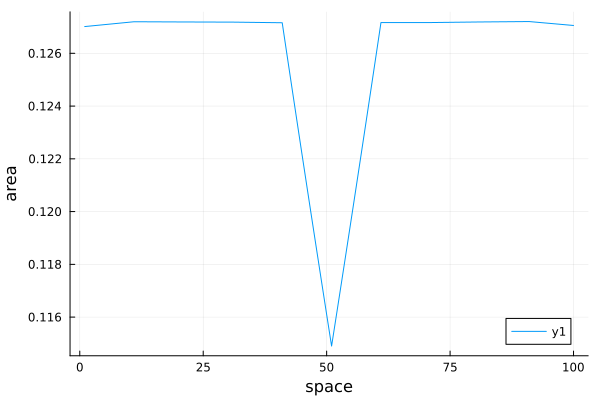

In [12]:
plot(Atrain1[1,:])
xlabel!("space")
ylabel!("area")

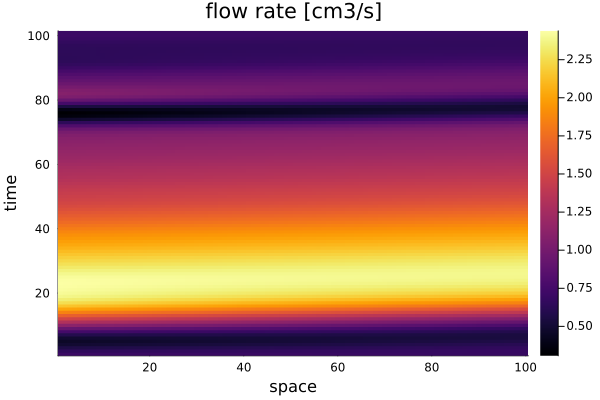

In [13]:
heatmap(ytrain2[:,:,1])
xlabel!("space")
ylabel!("time")
title!("flow rate [cm3/s]")

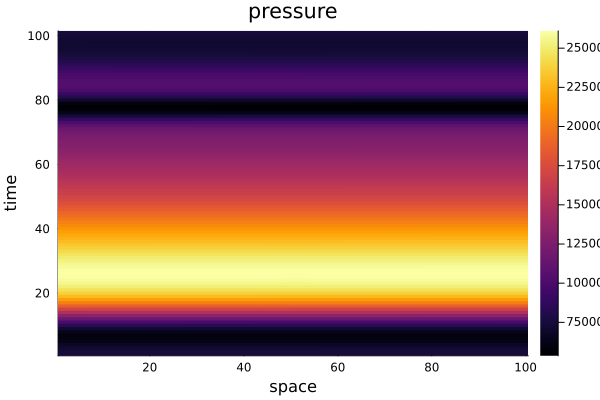

In [14]:
heatmap(ptrain[:,:,1])
xlabel!("space")
ylabel!("time")
title!("pressure")

In [15]:
path_to_working_directory="/home/tschala/research/LANL/juliaDiffProgExample/"

include("$path_to_working_directory/src/numerical_derivatives.jl");
include("$path_to_working_directory/src/train_utils.jl");

In [16]:
N = size(u01,1)
dx = L/N                      # spatial step
x = 0.0 : dx : (L-dx)         # discretized spatial dimension 
# finite-difference schemes

#first order derivatives
∂x1_center = f1_secondOrder_central(N,dx);
∂x1_forward = f1_secondOrder_forward(N,dx);
∂x1_backward = f1_secondOrder_backward(N,dx);

# use central difference for the majority
∂x1 = ∂x1_center
# use forward and backward difference near the boundaries
∂x1[1,:]=∂x1_forward[1,:]
∂x1[end,:] = ∂x1_backward[end,:]

#second order derivatives
∂x2_center = f2_secondOrder_central(N,dx);
∂x2_forward = f2_secondOrder_forward(N,dx);
∂x2_backward = f2_secondOrder_backward(N,dx);

# use central difference for the majority
∂x2 = ∂x2_center;
# use forward and backward difference near the boundaries
∂x2[1,:]=∂x2_forward[1,:];
∂x2[end,:] = ∂x2_backward[end,:];

In [17]:

# NN embedded in PDE for Differential programming
# Define the network architecture with initialization
hidden_dim = 10

ann = Chain(
    Dense(N, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, N, init = Flux.glorot_uniform)
)

Chain(
  Dense(100 => 10, tanh),               # 1_010 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 100),                     # 1_100 parameters
)                   # Total: 8 arrays, 2_330 parameters, 9.602 KiB.

In [18]:
# flatten parameters in NN for learning.                
p, re = Flux.destructure(ann);
ps = deepcopy(p)
p_size = size(p,1);
println("Number of parameters in neural network: $p_size"); 

Number of parameters in neural network: 2330


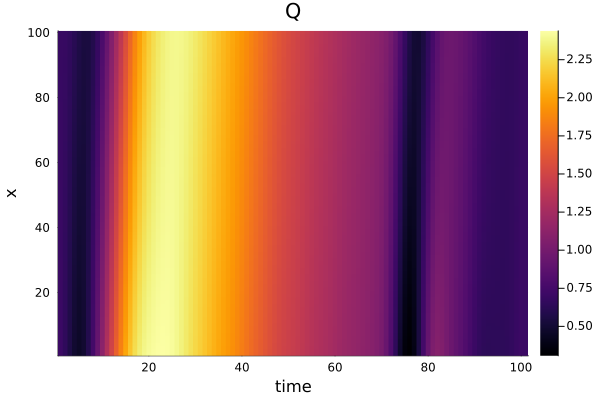

In [19]:
ytrain = permutedims(ytrain2[:,:,:],(2,3,1))

heatmap(ytrain[:,1,:])
xlabel!("time")
ylabel!("x")
title!("Q")

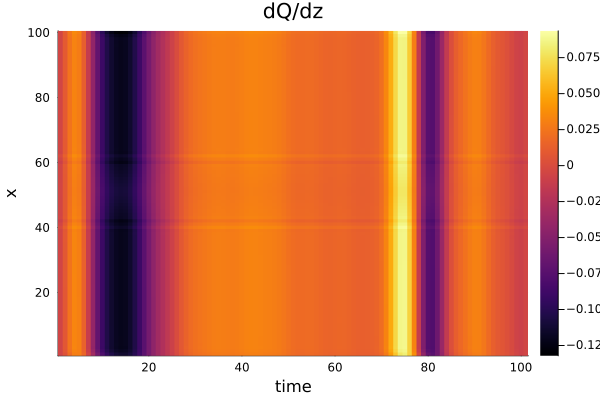

In [20]:
#plot derivatives for sanity check
heatmap(∂x1*ytrain[:,1,:])
xlabel!("time")
ylabel!("x")
title!("dQ/dz")

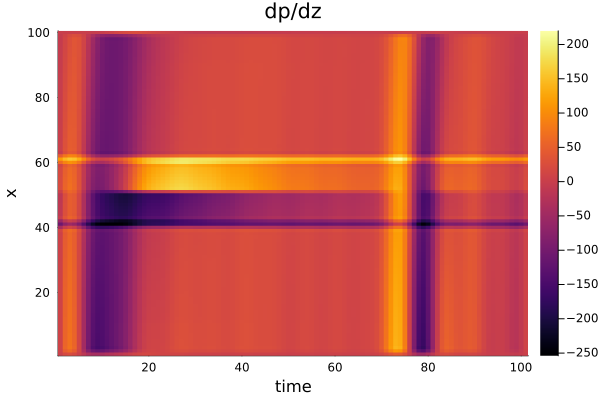

In [21]:
prestrain = permutedims(ptrain[:,:,:],(2,3,1))
heatmap(∂x1*prestrain[:,1,:])
xlabel!("time")
ylabel!("x")
title!("dp/dz")

In [22]:
δ = 1/3;  #profile parameters
ν = 0.04; # viscosity in CGS
ρ = 1.06; #density in CGS
Nprof = -8*π*ν;  #profile parameters

In [23]:
# # Define time-dependent variables
function interpolate_variables(t, vector)
    # t - dependent variable, could be time or space (z) too
    #      if t is time then use dt, if it's space use dz, same with T <--> L
    # vector - data vector with values at distinct t locations
    #
    # This function interpolates values such that we can access the values from vector
    # not just at the original data points but anywhere in between
    

    # Find the two closest points in vector
    #caculate the time index that's closest to time t

    t_index = Int(floor(t / dt)) + 1

    # calculate local time fraction between the grid points
    t_frac = (t - (t_index - 1) * dt) / dt

    # Perform linear interpolation between data points in vector
    # if we are at the last timesteps just copy the value cause t_index+1 will not exist
    if t == T
        vector_interp = vector[:,:,t_index]
        
    else
        vector_interp = (1 - t_frac) * vector[:,:,t_index] + t_frac * vector[:,:,t_index + 1]
    end
    
    # return the interpolated value of vector at time(space) = t
    return vector_interp
end


# define interpolate function
interp_func(t) = interpolate_variables(t, atrain)

interp_func (generic function with 1 method)

In [24]:
function learn_1DBlood(u, p, t, interp_func, p_interp_func)
    Φ = re(p)  # restructure flattened parameter vector into NN architecture.
    
    #interp_func - interpolates area to the current t
    #p_interp_func - interpolates pressure to current t
    
    # omit the pressure term for now:  - interp_func(t) ./ ρ .* (∂x1 * p_interp_func(t)) 
    #- (1+δ) .* (∂x1* ((u .^ 2) ./ interp_func(t))) + Nprof .* u ./ interp_func(t) + ν .* (∂x2*u)
    
    
#     println("time t: ", t)
#     println("advection term d/dz(Q^2/S): ", sum((1+δ) .* (∂x1* ((u .^ 2) ./ interp_func(t)))))
#     println("viscous resistance N*Q/S: ", sum(Nprof .* u ./ interp_func(t)))
#     println("Diffusion: nu*d^2Q/dz^2: ", sum(ν .* (∂x2*u)))
#     println("Mean area S: ", mean(interp_func(t)))
#     println("Mean Previous flow rate Q:", mean(u), ", std Q:", std(u))
#     println("Mean Q^2/S:", mean((u .* u) ./ interp_func(t)))
#     println("dp/dz term: ", sum(- interp_func(t) ./ ρ .* (∂x1 * p_interp_func(t))))
#     println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
#     flush(stdout)
    
#     plotQ = plot(u)
#     display(plot(plotQ))
#     sleep(1)
    return Φ(u)
end

learn_1DBlood (generic function with 1 method)

In [25]:
# if RK4 - then uses the self-implemented RK4
# if Tsit5 - uses callback
# at the moment both crash :(
ode_solver = "RK4"
output_dir = "/home/tschala/research/LANL/some_physics_testNODE"
working_dir = output_dir

"/home/tschala/research/LANL/some_physics_testNODE"

In [26]:
# Runge-Kutta solver
function rk4_solve(prob, θ, dt)
    t0, tf = prob.tspan
    u0 = prob.u0
    f = prob.f
    
    num_steps = Int(round((tf - t0) / dt))
    t = collect(range(t0, tf, step=dt))

    u_all = copy(u0)

    u = copy(u0)
    
    for i in 1:num_steps
        ti = t[i]
        println("time:", ti)
        k1 = f(u, θ, ti)
        k2 = f(u .+ dt/2 .* k1, θ, ti + dt/2)
        k3 = f(u .+ dt/2 .* k2, θ, ti + dt/2)
        k4 = f(u .+ dt .* k3, θ, ti + dt)

        u_new = u .+ dt/6 .* (k1 .+ 2*k2 .+ 2*k3 .+ k4)
        
        # to avoid mutating arrays use hcat for saving the solutions
        u_all = hcat(u_all, u_new)
        
        u = copy(u_new)


    end

    num_rows, num_cols = size(u0)

    u_matrix = reshape(hcat(u_all...), num_rows, num_cols, num_steps + 1)

    return u_matrix
end


rk4_solve (generic function with 1 method)

In [27]:
#short test problem for sanity check that RK4 is doing what we expect
function test_rk4_solve()
    # Define the ODE problem
    tspan = (0.0, 1.0)
    u0 = [[1.0, 2.0] [1.0, 2.0]]  # Initial conditions
    θ = 2.0  # Parameters
    dt = 0.01  # Time step
    f(u, θ, t) = [0, θ * u[2,2]]  # ODE function

    prob = ODEProblem(f, u0, tspan)

    # Solve the ODE using rk4_solve
    u_matrix = rk4_solve(prob, θ, dt)
    
    # Check the size of the solution array
    @test size(u_matrix) == (2, 2, 101)  # Assuming 100 time steps
    
    
    # Check the solution against analytical solution: 2*e^(2t)
    trange = collect(0.0:0.01:1.0)
    an_sol = 2*exp.(2*trange)
    
    @test u_matrix[2,2,:] ≈ an_sol atol=1e-6
    @test u_matrix[2,1,:] ≈ an_sol atol=1e-6
    
    return u_matrix
end


test_rk4_solve (generic function with 1 method)

In [28]:
#check if it passes the basic test
#if it works it should return nothing!
test_rk4_solve();

time:0.0
time:0.01
time:0.02
time:0.03
time:0.04
time:0.05
time:0.06
time:0.07
time:0.08
time:0.09
time:0.1
time:0.11
time:0.12
time:0.13
time:0.14
time:0.15
time:0.16
time:0.17
time:0.18
time:0.19
time:0.2
time:0.21
time:0.22
time:0.23
time:0.24
time:0.25
time:0.26
time:0.27
time:0.28
time:0.29
time:0.3
time:0.31
time:0.32
time:0.33
time:0.34
time:0.35
time:0.36
time:0.37
time:0.38
time:0.39
time:0.4
time:0.41
time:0.42
time:0.43
time:0.44
time:0.45
time:0.46
time:0.47
time:0.48
time:0.49
time:0.5
time:0.51
time:0.52
time:0.53
time:0.54
time:0.55
time:0.56
time:0.57
time:0.58
time:0.59
time:0.6
time:0.61
time:0.62
time:0.63
time:0.64
time:0.65
time:0.66
time:0.67
time:0.68
time:0.69
time:0.7
time:0.71
time:0.72
time:0.73
time:0.74
time:0.75
time:0.76
time:0.77
time:0.78
time:0.79
time:0.8
time:0.81
time:0.82
time:0.83
time:0.84
time:0.85
time:0.86
time:0.87
time:0.88
time:0.89
time:0.9
time:0.91
time:0.92
time:0.93
time:0.94
time:0.95
time:0.96
time:0.97
time:0.98
time:0.99


In [29]:
prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func, p_interp_func), u01, tspan, p) ;

#define callback action
function dose(integrator)     
   #for now just print time
   println("t: ",integrator.t)
end

# condition when to do callback
function condition(u,t,integrator)
   #do callback at each iteration
    return true 
end

function predict(θ,prob,bc_left)
    # Define the callback for enforcing boundary conditions
    
#     cb = PeriodicCallback(dose, dt::Number, initial_affect = true,save_positions=(false,false))
    cb = DiscreteCallback(condition, dose,save_positions=(false,false))
    
    if ode_solver == "Tsit5"
        sol = Array(solve(prob,Tsit5(),p=θ,dt=dt,saveat=dt,adaptive=false, callback = cb))
        println("size sol", size(sol))
    elseif ode_solver == "RK4"
        #sol = Array(solve(prob,RK4(),p=θ,dt=dt,saveat=dt))
        sol = rk4_solve(prob, θ, dt)
        println("sol size RK4:", size(sol))
    elseif ode_solver == "Rosenbrock23"
        sol = Array(solve(prob,Rosenbrock23(),p=θ,dt=dt,saveat=dt))
    end
    
    #right now don't do anything with boundary conditions
    
    #hardcode boundary conditions after the neural network output
    #bc_zeros = zeros(size(sol[1,:,:]))
    #multiply = Float32.(vcat(reshape(bc_zeros, 1, size(bc_zeros,1),size(bc_zeros,2)),ones(size(sol)[1]-1,size(sol)[2],size(sol)[3])))

    #add = Float32.(vcat(reshape(bc_left', 1, size(bc_left',1),size(bc_left',2)),zeros(size(sol)[1]-1,size(sol)[2],size(sol)[3])))
    
    #multiply is zero at the BC and one everywhere else
    #add is equal to the BC at the BC location and zero everywhere else
    
#     return sol#.*multiply.+add
    return sol
end 

predict (generic function with 1 method)

In [30]:
function loss(θ, ytrain21, prob,bc_left)
    pred = predict(θ, prob,bc_left)
    
    println("pred size:", size(pred))
    
    # pred size is space x batch x time
    l = sum(abs2,(pred - ytrain21)) 
    println("loss:",l)
    return l, pred
end


# l , pred = loss(ps,ytrain21,prob)

# training optimizer definition
adtype = Optimization.AutoZygote() ;
optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain21,prob,bc_left),adtype) ;

In [31]:
path_checkpoint=nothing
optimizer_choice1 = "ADAM"
optimizer_choice2 = "BFGS"

"BFGS"

In [32]:
# process user choices

if !isdir(working_dir)
    mkdir(working_dir)
end
output_dir = working_dir*"/output/"
cd(working_dir) #switch to working directory
if !isdir(output_dir)
    mkdir(output_dir)
end
println("optimizer 1 is $optimizer_choice1")
if !isnothing(optimizer_choice2)
    println("optimizer 2 is $optimizer_choice2 optimizer")
end

println("ODE Time integrator selected:", ode_solver)


optimizer 1 is ADAM
optimizer 2 is BFGS optimizer
ODE Time integrator selected:RK4


In [33]:
# restart training from previaous checkpoint if it exists, else start 
# fresh training.
if !isnothing(path_checkpoint)
    checkpoint_exists = isfile(path_checkpoint)
    if checkpoint_exists
        println("Checkpoint exists!")
        ckpt_restart = jldopen(path_checkpoint,"r")
        res1 = ckpt_restart["ckpt"]
        uinit = copy(res1.u)
    else
        println("ckpt path given, but no file found!")
    end
else
    uinit = deepcopy(ps)
    println("Fresh training initialized")
end

Fresh training initialized


In [ ]:
n_epochs = 10

#set time horizon settings
# nt = 100
#set batch size
batch_size = 10
println("Batch size:", batch_size)
#training batches
batch_iterations = Int(size(ytrain2,3)/batch_size)
#testing batches
test_batch_iterations = Int(ceil(size(ytest2,3)/batch_size));

list_loss_train = []
list_loss_epoch = []
list_loss_test = []
list_loss_epoch_test = []
# epochs loop
learning_rate = 0.5
for j in 1:n_epochs
    println("Start training epoch ",j)
    loss_tot = 0.0
    loss_tot_test = 0.0

        # loop over different waveforms
        for i in 1:batch_iterations

            println("waveform batch: ",i, "/",batch_iterations)



            flush(stdout)
            #reorder ytrain, atrain and dAdz to [space, batch_size, time]
            # batch size should be second column
            ytrain = permutedims(ytrain2[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
            atrain = permutedims(Atrain[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
        
            #define boundary condition for the current batch
            bctrain = bc_flow[:,batch_size*(i-1)+1:batch_size*i]
        
            #reorder pressure values as well
            prestrain = permutedims(ptrain[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))


            #define function for interpolating area to the actual time location for the ODE
            interp_func(t) = interpolate_variables(t, atrain)
            p_interp_func(t) = interpolate_variables(t, prestrain)
            
        
            #define optimization problem
            prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func, p_interp_func), ytrain[:,:,1], tspan, p);
    
            #do one predict step just to check if the integrator is working without backprop and all that
            predict(uinit,prob,bctrain)
        
            optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain[:,:,:],prob, bctrain),adtype) ;

            println("Using $optimizer_choice1 optimizer")
            println("Sum of params:", sum(uinit))

            # Change learning rate for ADAM optimizer, BFGS doesn't use it
            if j % 3 == 0
                learning_rate = learning_rate*0.5
                println("Changing learning rate to:",learning_rate)
            end

            uinit = train_loop(uinit,adtype,optf,train_maxiters,learning_rate,optimizer_choice1)
            println("Sum of params:", sum(uinit))

            if !isnothing(optimizer_choice2)
                println("Switching to $optimizer_choice2 optimizer")

                uinit = train_loop(uinit,adtype,optf,train_maxiters*100,learning_rate,optimizer_choice2)

                println("Sum of params:", sum(uinit))

            end
        
            #calculate final loss and push it to the list
            prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func,p_interp_func), ytrain[:,:,1], tspan, p);
            l , pred = loss(uinit,ytrain[:,:,:],prob,bctrain)
            loss_tot = loss_tot + l

            push!(list_loss_train, l)
            println("Epoch ", j, " loss:", l)


            # plot solution for comparison
            plot1 = heatmap(pred[:,1,:], color=:viridis, title = "neural ODE flow rate")
            xlabel!("time")
            ylabel!("x")

            plot2 = heatmap(ytrain[:,1,:], title="1D - flow rate", color=:viridis)
            xlabel!("time")
            ylabel!("x")
            display(plot(plot1,plot2,layout = (2, 1)))
            sleep(1)
        end
    
    
        #testing loop
        println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        println("Testing:")

        for i in 1:test_batch_iterations

            println("waveform batch: ",i, "/",test_batch_iterations)

            #reorder ytrain to (spatial location, batch_size, time)
            if i!=test_batch_iterations
                ytest = permutedims(ytest2[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
                atest = permutedims(Atest[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
                bctest = bc_flow_test[:,batch_size*(i-1)+1:batch_size*i]
                prestest = permutedims(ptest[:,:,batch_size*(i-1)+1:batch_size*i],(2,3,1))
            else
                ytest = permutedims(ytest2[:,:,batch_size*(i-1)+1:end],(2,3,1))
                atest = permutedims(Atest[:,:,batch_size*(i-1)+1:end],(2,3,1))
                bctest = bc_flow_test[:,batch_size*(i-1)+1:end]
                prestest = permutedims(ptest[:,:,batch_size*(i-1)+1:end],(2,3,1))
            end
            

            #define function for interpolating area and dA/dz to the actual spatial location for the ODE
            interp_func(t) = interpolate_variables(t, atest)
            p_interp_func(t) = interpolate_variables(t, prestest)

            #calculate final loss and push it to the list
            prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func, p_interp_func), ytest[:,:,1], tspan, p);
            l , pred = loss(uinit,ytest[:,:,:],prob,bctest)
            loss_tot_test = loss_tot_test + l

            push!(list_loss_test, l)
            println("Test loss:",l )

#             #calculate derivative error
#             dudt = 0.0
#             batch = size(ytest)[2]
#             #sum error across all samples in the batch
#             for i in 1:batch
#                 dudt +=sum(abs2,repeat(∂t1, outer=(1, 1, batch))[:,:,i] * pred[:,i,:] - repeat(∂t1, outer=(1, 1, batch))[:,:,i] * ytest[:,i,:])
#             end

#             println("Test du/dt error:",dudt)
            # plot solution for comparison
            plot1 = heatmap(pred[:,1,:], color=:viridis, title = "neural ODE flow rate")
            xlabel!("time")
            ylabel!("x")

            plot2 = heatmap(ytest[:,1,:], title="1D - flow rate", color=:viridis)
            xlabel!("time")
            ylabel!("x")
            display(plot(plot1,plot2,layout = (2, 1)))
            sleep(1)
        end


push!(list_loss_epoch, loss_tot/(size(ytrain2,3)))
push!(list_loss_epoch_test, loss_tot_test/(size(ytest2,3)))
println("Epoch ", j, " mean train loss:", loss_tot/(size(ytrain2,3)))
println("Epoch ", j, " mean test loss:", loss_tot_test/(size(ytest2,3)))
end


Batch size:10
Start training epoch 1
waveform batch: 1/1
time:0.0


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(100 => 10, tanh)  # 1_010 parameters
│   summary(x) = "100×10 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/EHgZm/src/layers/stateless.jl:60


time:0.01
time:0.02
time:0.03
time:0.04
time:0.05
time:0.06
time:0.07
time:0.08
time:0.09
time:0.1
time:0.11
time:0.12
time:0.13
time:0.14
time:0.15
time:0.16
time:0.17
time:0.18
time:0.19
time:0.2
time:0.21
time:0.22
time:0.23
time:0.24
time:0.25
time:0.26
time:0.27
time:0.28
time:0.29
time:0.3
time:0.31
time:0.32
time:0.33
time:0.34
time:0.35
time:0.36
time:0.37
time:0.38
time:0.39
time:0.4
time:0.41
time:0.42
time:0.43
time:0.44
time:0.45
time:0.46
time:0.47
time:0.48
time:0.49
time:0.5
time:0.51
time:0.52
time:0.53
time:0.54
time:0.55
time:0.56
time:0.57
time:0.58
time:0.59
time:0.6
time:0.61
time:0.62
time:0.63
time:0.64
time:0.65
time:0.66
time:0.67
time:0.68
time:0.69
time:0.7
time:0.71
time:0.72
time:0.73
time:0.74
time:0.75
time:0.76
time:0.77
time:0.78
time:0.79
time:0.8
time:0.81
time:0.82
time:0.83
time:0.84
time:0.85
time:0.86
time:0.87
time:0.88
time:0.89
time:0.9
time:0.91
time:0.92
time:0.93
time:0.94
time:0.95
time:0.96
time:0.97
time:0.98
time:0.99
sol size RK4:(100, 

In [ ]:
# # plot loss as a function of epochs
# p3 = plot([list_loss_epoch,list_loss_epoch_test], yaxis=:log, label = ["train" "test"])
# ylabel!("loss")
# xlabel!("epochs")
# png("dQdt_1DBlood_loss.png")
# display(p3)

### Load the final learnt parameters and do inference ###

In [ ]:
# p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 5
# u01 = u0[:,wv]

# p = p_learn["p"]

# T = 1                      # total time
# tsteps = 0.0:dt:T             # discretized time dimension
# tspan = (0,T)    

# begin 
#     learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[:,wv]), u01, tspan, p)     # p changes after training   
#     if ode_solver == "Tsit5"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "RK4"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "Rosenbrock23"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     end
#     save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#     println("saved trained solution")
# end

# sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_testNODE_trained.jld2");

# plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))

In [ ]:
# p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 2
# u01 = u0[:,wv]

# p = p_learn["p"]

# T = 1                      # total time
# tsteps = 0.0:dt:T             # discretized time dimension
# tspan = (0,T)    

# begin 
#     learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[:,wv]), u01, tspan, p)     # p changes after training   
#     if ode_solver == "Tsit5"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "RK4"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "Rosenbrock23"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     end
#     save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#     println("saved trained solution")
# end

# sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_testNODE_trained.jld2");

# plot1 = heatmap(sol_learn["single_stored_object"][:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))

### Step-by-step inference ###

In [ ]:
# p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 1
# u01 = u0[:,wv]
# p = p_learn["p"]

# nt = 10
# T = dt * nt  # total time
# tspan = (0.0, T)
# tsteps = 0:dt:tspan[2]  # create time vector  

In [ ]:
# sol_list = []
# for k in 2:11
#     println("t:",((k-2)*nt+1)*dt)
#     begin 
#         println(sum(u01))
#         learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[k-1,wv]), u01[:,end], tspan, p)     # p changes after training   
# #         u01 = ytrain2[(k-2)*nt+1,:,wv]
# #         learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, bc_flow[(k-2)*nt+1,wv]), u01, tspan, p)     # p changes after training   

            
#         if ode_solver == "Tsit5"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         elseif ode_solver == "RK4"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         elseif ode_solver == "Rosenbrock23"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         end
#         save_object(output_dir*"/sol_learn_paramBC_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#         println("saved trained solution")
#     end

#     sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_paramBC_testNODE_trained.jld2");
#     solution = sol_learn["single_stored_object"]
#     #overwrite initial condition by the solution
#     u01 = solution[:,2:end]
#     push!(sol_list,u01)
#     l = sum(abs2,u01-ytrain2[(k-2)*nt+1:(k-1)*nt,:,wv]')
#     println("Loss: ",l)
    
    
    
# # multiply = Float32.(vcat(zeros(size(solution)[2])',ones(size(solution)[1]-1,size(solution)[2])))
# # add = Float32.(vcat( bc_flow[:,wv]',zeros(size(solution)[1]-1,size(solution)[2])))
# # sol = solution.*multiply.+add
# end

# combined_sol = hcat(sol_list...);

# # sol = combined_sol[:,2:2:end];
# sol = combined_sol[:,:];

In [ ]:
# plot1 = heatmap(sol[:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))